In [1]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

import pymorphy3
import razdel
from razdel import sentenize
from tqdm.notebook import tqdm
from alive_progress import alive_bar
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

morph = pymorphy3.MorphAnalyzer()

In [2]:
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/dasha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_excel("./data/summary_prod_loc_big.xlsx")

/home/dasha/.pyenv/versions/3.11.2/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
df.shape

(30748, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30748 entries, 0 to 30747
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   news_id        30748 non-null  int64         
 1   rel_id         30748 non-null  object        
 2   text           30748 non-null  object        
 3   summary_ru     30748 non-null  object        
 4   summary_en     30748 non-null  object        
 5   raw_product    30748 non-null  object        
 6   product        16988 non-null  object        
 7   raw_locations  30748 non-null  object        
 8   locations      30748 non-null  object        
 9   news_date      30748 non-null  object        
 10  user_checked   30748 non-null  object        
 11  date_checked   18979 non-null  datetime64[ns]
 12  url            30748 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(11)
memory usage: 3.0+ MB


В датасете собраны все возможные тексты, для которых есть сырые продукты (определенные NER) и страны (уже нормированы).

Убраем дубли из данных

In [6]:
df.duplicated().sum()

1873

Убираем полные дубли

In [7]:
df = df.drop_duplicates()

Дубли по столбцам. Для начала сортируем данные по дате, чтобы по keep='last' оставить дубли с более поздним саммари, т.к. с развитем проекта экспертность аннотаторов повысилась и саммари стали более короткими, емкими, но при этом удовлетворяющими условиям заказчика.

In [8]:
df = df.sort_values('date_checked')

In [9]:
df = df.drop_duplicates(subset="news_id", keep='last')
df = df.drop_duplicates(subset="rel_id", keep="last")
df = df.drop_duplicates(subset="text", keep="last")
df = df.drop_duplicates(subset="url", keep="last")
df.shape

(26921, 13)

Определяем язык текста, чтобы оставить саммари только на нужном языке, также лемматизируем тексты, саммари и продукты.

In [10]:
df.raw_product = df.raw_product.str.replace("CLASSIFIED_BY_TEXT, ", "")
df.raw_product = df.raw_product.str.replace("CLASSIFIED_BY_TEXT", "")

In [11]:
def get_ru_prod(text):
    prods = []
    for words in text.split(", "):
        words = words.lower()
        if " " in words:
            prod = " ".join(
                [morph.parse(word)[0].normal_form for word in words.split()]
            )
        else:
            prod = morph.parse(words)[0].normal_form
        prods.append(prod)
    return set(prods)

Добавим разные параметры для полных и кратких текстов: количество слов, количество уникальных слов, количество продуктов и стран.

In [12]:
def get_en_prod(text):
    prods = []
    for words in text.split(", "):
        words = words.lower()
        if " " in words:
            prod = " ".join([lemmatizer.lemmatize(token) for token in words.split()])
        else:
            prod = lemmatizer.lemmatize(words)
        prods.append(prod)
    return set(prods)

In [13]:
def get_features(df):
    with tqdm(total=df.shape[0]) as pbar:
        for i, row in df.iterrows():
            if re.findall("[А-Яа-яёЁ]+", row['text']):
                df.at[i, "summary"] = row["summary_ru"]
                df.at[i, 'lang'] = 'ru'
                text_words = [word.text for word in razdel.tokenize(row["text"].lower())]
                summary_words = [word.text for word in razdel.tokenize(row["summary_ru"].lower())]
                text_lemmas = [morph.parse(word)[0].normal_form for word in text_words]
                summary_lemmas = [morph.parse(word)[0].normal_form for word in summary_words]
                df.at[i, "text_words"] = text_words
                df.at[i, "summary_words"] = summary_words
                df.at[i, "text_lemmas"] = text_lemmas
                df.at[i, "summary_lemmas"] = summary_lemmas
                df.at[i, "product_lemmas"] = get_ru_prod(row["raw_product"])
                df.at[i, "country_lemmas"] = get_ru_prod(row["raw_locations"])
                df.at[i, "num_summary_sents"] = len(list(sentenize(row["summary_ru"])))
            else:
                df.at[i, "summary"] = row["summary_en"]
                df.at[i, "lang"] = "en"
                text_words = word_tokenize(row["text"].lower())
                summary_words = word_tokenize(row["summary_en"].lower())
                text_lemmas = [lemmatizer.lemmatize(token) for token in text_words]
                summary_lemmas = [lemmatizer.lemmatize(token) for token in summary_words]
                df.at[i, "text_words"] = text_words
                df.at[i, "summary_words"] = summary_words
                df.at[i, "text_lemmas"] = text_lemmas
                df.at[i, "summary_lemmas"] = summary_lemmas
                df.at[i, "product_lemmas"] = get_en_prod(row["raw_product"])
                df.at[i, "country_lemmas"] = get_en_prod(row["raw_locations"])
                df.at[i, "num_summary_sents"] = len(sent_tokenize(row["summary_en"]))

            pbar.update(1)
    return df

In [14]:
df["summary"] = "-"
df["lang"] = "-"
df["text_words"] = "-"
df["summary_words"] = "-"
df["text_lemmas"] = "-"
df["summary_lemmas"] = "-"
df["product_lemmas"] = "-"
df["country_lemmas"] = "-"
df["num_summary_sents"] = -1

In [15]:
df = get_features(df)

  0%|          | 0/26921 [00:00<?, ?it/s]

In [16]:
df["text_len"] = df["text_words"].apply(len)
df["summary_len"] = df["summary_words"].apply(len)
df["text_unique_len"] = df["text_words"].apply((lambda x: len(set(x))))
df["summary_unique_len"] = df["summary_words"].apply(lambda x: len(set(x)))
df["prod_num"] = df["product_lemmas"].apply(len)
df["locs_num"] = df["locations"].apply(lambda x: len(set(x.split(", "))))
df["prod_locs_num"] = df["prod_num"] + df["locs_num"]
df["raw_locs_num"] = df["country_lemmas"].apply(len)

Убираем ненужные столбцы

In [17]:
df.drop(
    [
        "news_id",
        "rel_id",
        "summary_ru",
        "summary_en",
        "user_checked",
        "date_checked",
    ],
    axis=1,
    inplace=True,
)

In [18]:
df.sample(5)

,text,raw_product,product,raw_locations,locations,news_date,url,summary,lang,text_words,...,country_lemmas,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num
7164,A VinFast VF8 electric car on display in a sho...,"A Vinfast VF8 electric car, cars, EV, vehicles...","A Vinfast VF8 electric car, cars, vehicles, Vi...","U. S., Vietnam, Vietnamese","Вьетнам, США",2023-03-08,https://www.cnbc.com/2023/03/08/vietnam-ev-mak...,Vietnamese electric car manufacturer VinFast c...,en,"[a, vinfast, vf8, electric, car, on, display, ...",...,"{vietnam, vietnamese, u. s.}",2,290,49,162,40,5,2,7,3
17546,ЕС выделит 500 млн евро на закупку оружия для ...,вакцины,NaN,"Брюссель, европейские, испанская, Украина","ЕС, Европа и Северная Америка, Украина",2022-07-18,https://rossaprimavera.ru/news/998a4129,"На восстановление арсеналов европейских стран,...",ru,"[ес, выделит, 500, млн, евро, на, закупку, ору...",...,"{украина, испанский, брюссель, европейский}",2,162,35,119,31,1,3,4,4
24045,"МОСКВА, 8 мая — ПРАЙМ. Украина получила почти ...",,NaN,"Украина, украинское",Украина,2023-05-08,https://1prime.ru/finance/20230508/840551775.html,Украина получила почти 190 миллионов евро от В...,ru,"[москва, ,, 8, мая, —, прайм, ., украина, полу...",...,"{украина, украинский}",1,194,15,136,15,1,1,2,2
3801,Турция рассматривает возможность закупки у Рос...,"F-16, С-400 «триумф», Су-35",NaN,"Австралия, Вашингтон, Великобритания, Дания, И...","Европа и Северная Америка, Австралия и Океания",2022-09-24,https://rossaprimavera.ru/news/f67c57ca,"Турция, возможно, закупит у России Су-35 Турци...",ru,"[турция, рассматривает, возможность, закупки, ...",...,"{россия, великобритания, дания, италия, вашинг...",4,129,82,92,62,3,2,5,12
4812,Нефть умеренно дорожает на слухах о возможном ...,"Brent, WTI, нефть, топливо",NaN,"Китай, США","Китай, США, Саудовская Аравия",2022-10-20,https://www.interfax.ru/business/868876,Фьючерсы на нефть растут на надеждах на усилен...,ru,"[нефть, умеренно, дорожает, на, слухах, о, воз...",...,"{китай, сша}",4,348,112,228,78,4,3,7,2


Язык новостей

In [19]:
df['lang'].value_counts()

lang
ru    19543
en     7378
Name: count, dtype: int64

Год новости

In [20]:
df["news_date"] = df["news_date"].str[:4]

In [21]:
df["news_date"].value_counts()

news_date
2023    12863
2022    10224
2024     3492
2020      189
2021      153
Name: count, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26921 entries, 21047 to 30746
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                26921 non-null  object
 1   raw_product         26921 non-null  object
 2   product             14400 non-null  object
 3   raw_locations       26921 non-null  object
 4   locations           26921 non-null  object
 5   news_date           26921 non-null  object
 6   url                 26921 non-null  object
 7   summary             26921 non-null  object
 8   lang                26921 non-null  object
 9   text_words          26921 non-null  object
 10  summary_words       26921 non-null  object
 11  text_lemmas         26921 non-null  object
 12  summary_lemmas      26921 non-null  object
 13  product_lemmas      26921 non-null  object
 14  country_lemmas      26921 non-null  object
 15  num_summary_sents   26921 non-null  int64 
 16  text_len            269

In [23]:
df.to_csv('./data/text_sum_stats.csv', index=False)

In [24]:
# df = pd.read_csv('./data/text_sum_stats.csv')

Посмотрим корреляции и распределения

In [25]:
df.select_dtypes(include=np.number)

,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num
21047,2,363,43,241,39,2,3,5,12
21028,1,154,27,98,24,1,2,3,7
5215,1,209,15,134,15,1,9,10,4
5187,1,238,15,144,13,1,2,3,6
21061,1,189,21,116,20,2,1,3,2
...,...,...,...,...,...,...,...,...,...
30738,1,185,28,107,26,2,1,3,4
30741,1,51,13,42,13,2,1,3,4
30742,1,182,12,119,12,3,1,4,7
30743,1,543,15,299,14,3,1,4,6


<Axes: >

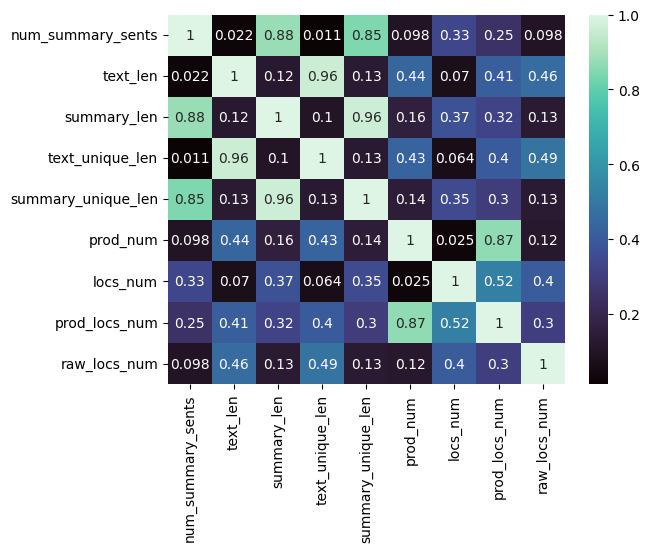

In [26]:
corr_m = df.select_dtypes(include=np.number).corr()
plt.figsize = (10, 8)
sns.heatmap(corr_m, annot=True, cmap="mako")

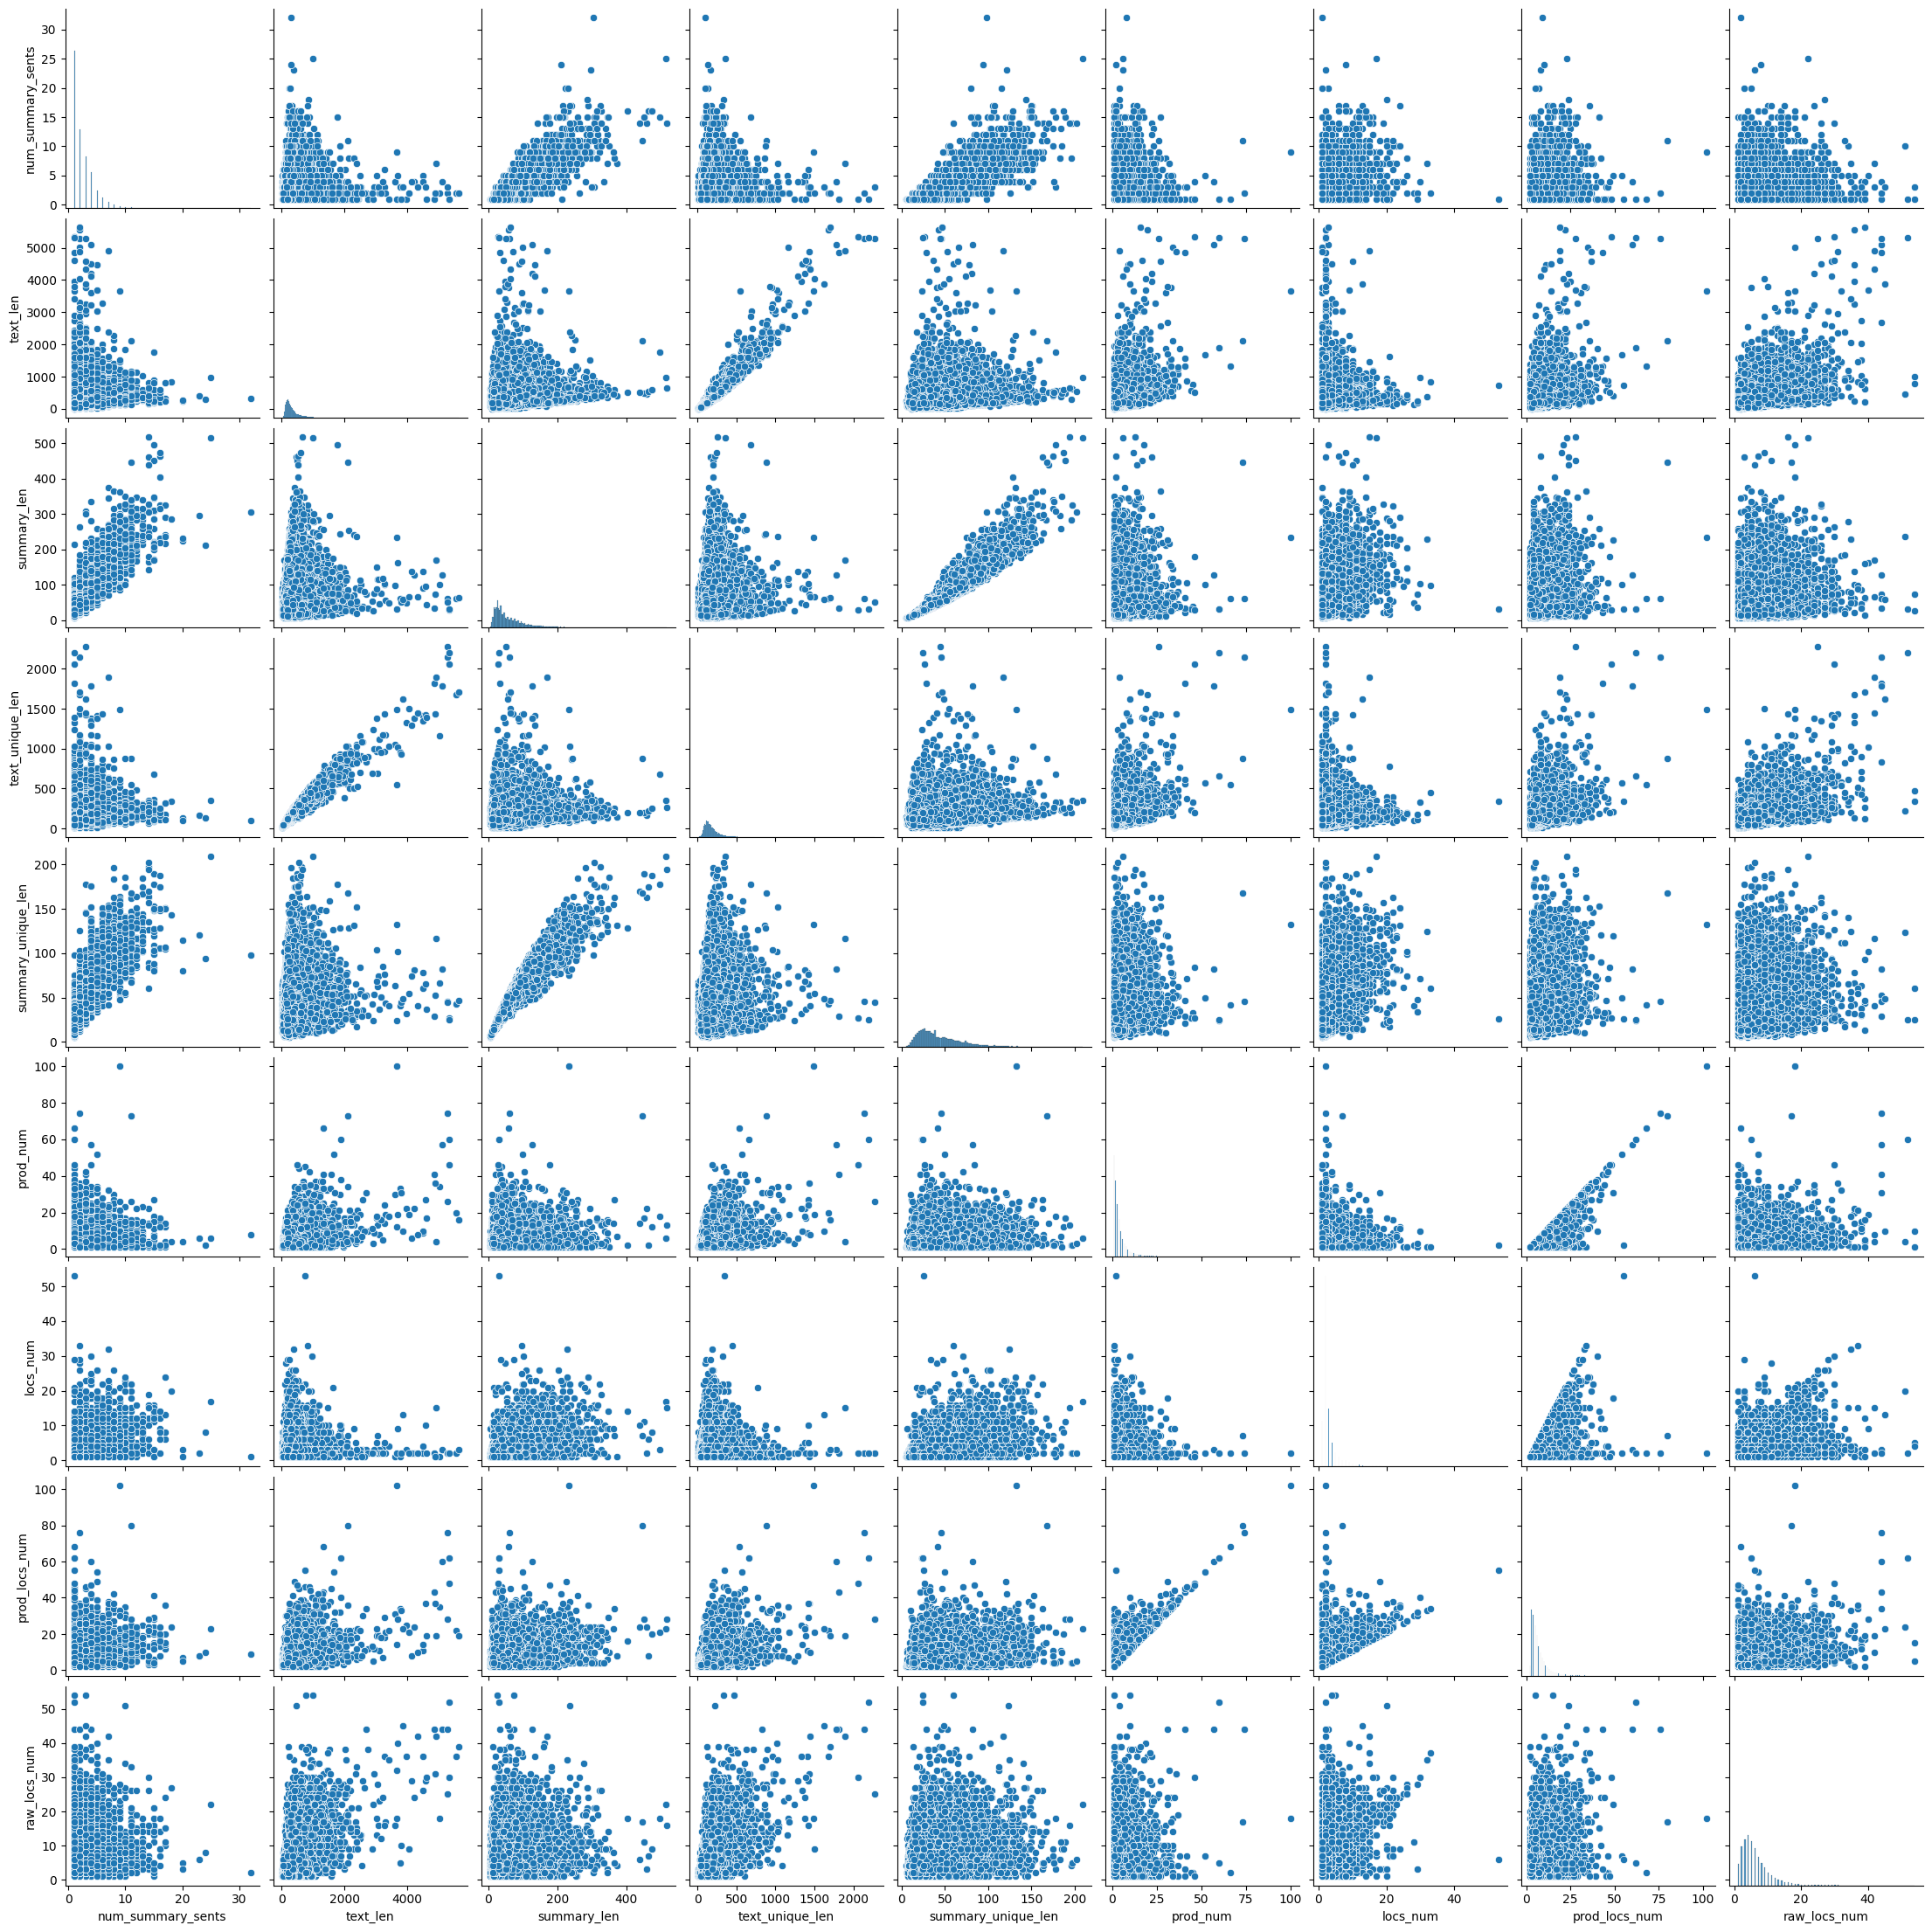

In [27]:
sns.pairplot(df)

Абсолютно логичная и неудивительная зависимость между длиной текста/саммари и количеством уникальных слов в тексте/саммари соответсвенно.

Нет сильной корреляции между количеством продукта, локаций (или их суммой) и длиной саммари, количесвтом предложений в саммари.

Посмотрим графики распределения слов 

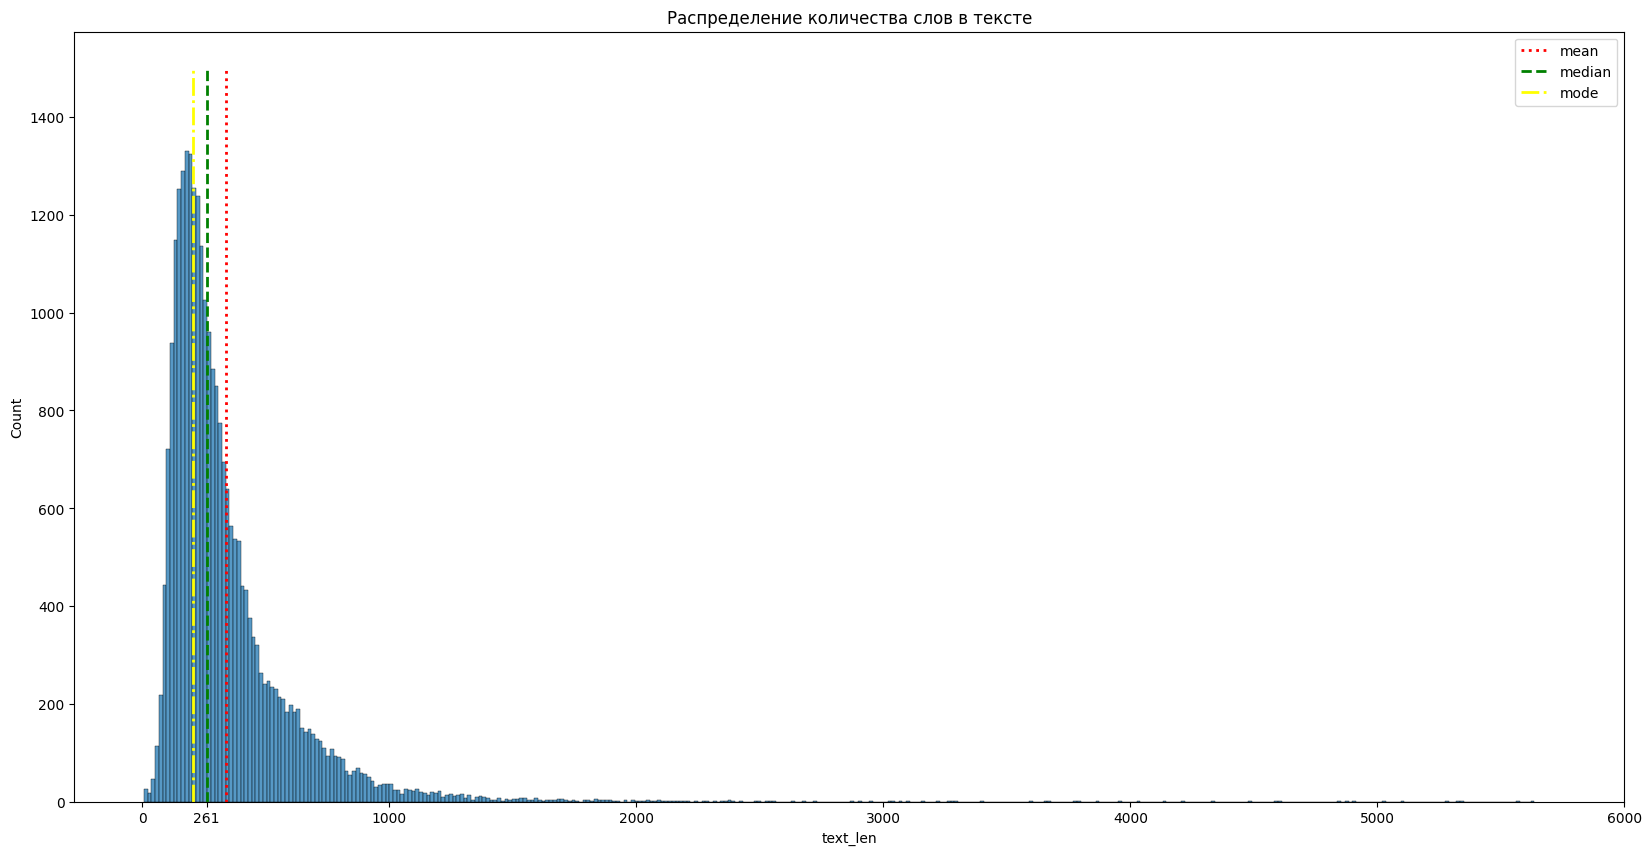

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.histplot(df, x="text_len")
plt.plot(
    [df.text_len.mean(), df.text_len.mean()],
    [0, 1500],
    label="mean",
    linestyle=":",
    linewidth=2,
    color="r",
)
plt.plot(
    [df.text_len.median(), df.text_len.median()],
    [0, 1500],
    label="median",
    linestyle="--",
    linewidth=2,
    color="g",
)
plt.plot(
    [df.text_len.mode()[0], df.text_len.mode()[0]],
    [0, 1500],
    label="mode",
    linestyle="-.",
    linewidth=2,
    color="yellow",
)
plt.title("Распределение количества слов в тексте")

xt = ax.get_xticks() 
xt=np.append(xt, np.round(df.text_len.median(), 1))
ax.set_xticks(xt[1:])
plt.legend()
plt.show()

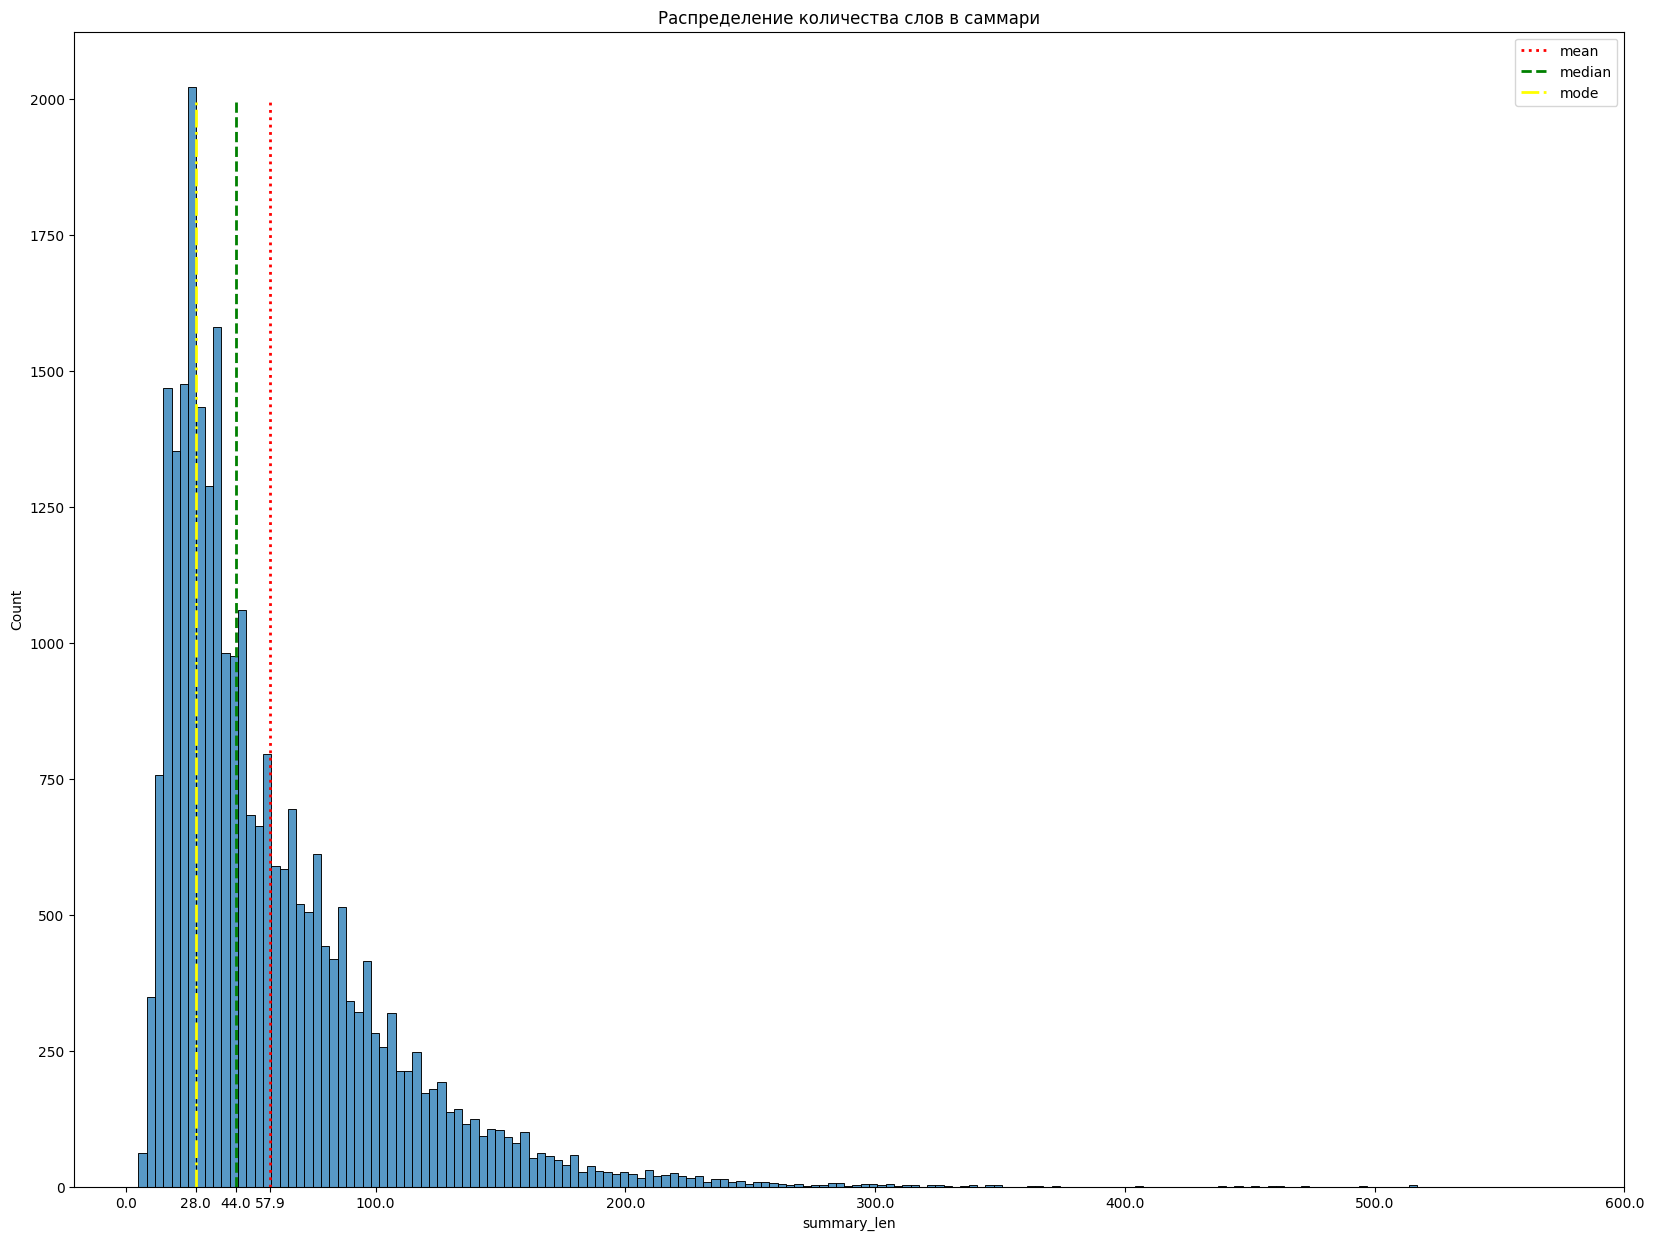

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
sns.histplot(df, x="summary_len")
plt.plot(
    [df.summary_len.mean(), df.summary_len.mean()],
    [0, 2000],
    label="mean",
    linestyle=":",
    linewidth=2,
    color="r",
)
plt.plot(
    [df.summary_len.median(), df.summary_len.median()],
    [0, 2000],
    label="median",
    linestyle="--",
    linewidth=2,
    color="g",
)
plt.plot(
    [df.summary_len.mode()[0], df.summary_len.mode()[0]],
    [0, 2000],
    label="mode",
    linestyle="-.",
    linewidth=2,
    color="yellow",
)
plt.title("Распределение количества слов в саммари")
xt = ax.get_xticks()
xt = np.append(
    xt,
    [
        df.summary_len.mode()[0],
        np.round(df.summary_len.median(), 1),
        np.round(df.summary_len.mean(), 1),
    ],
)
ax.set_xticks(xt[1:])
plt.legend()
plt.show()

<Figure size 600x600 with 0 Axes>

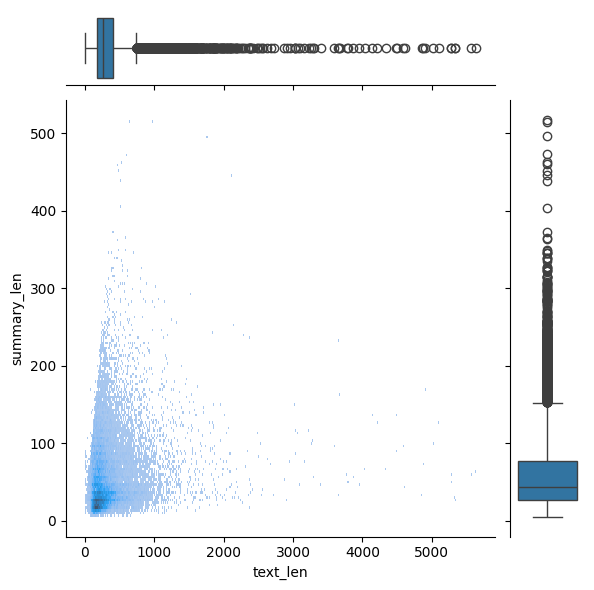

In [30]:
plt.figure(figsize=(6, 6))
g = sns.JointGrid(data=df, x="text_len", y="summary_len")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

Посмотрим на самые длинные саммари

In [31]:
df[df.summary_len > 300].shape

(43, 24)

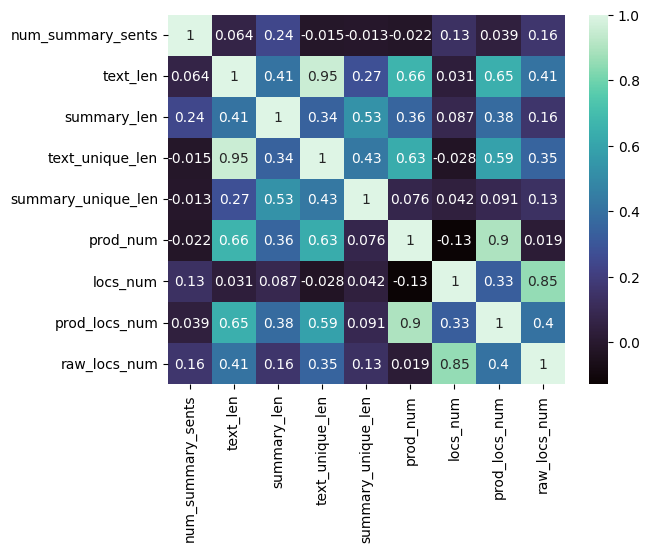

In [32]:
sns.heatmap(
    df[df.summary_len > 300].select_dtypes(include=np.number).corr(),
    annot=True,
    cmap="mako",
);

<Axes: >

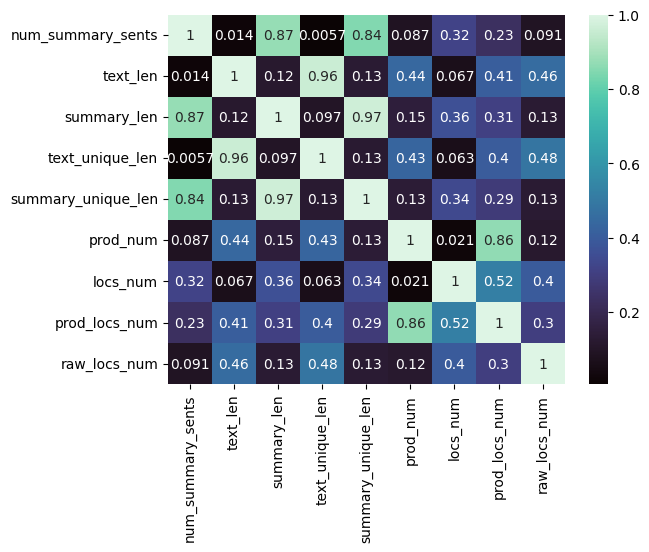

In [33]:
sns.heatmap(df[df.summary_len <= 300].select_dtypes(include=np.number).corr(), annot=True, cmap="mako")

Всего в датасете 43 саммари с количеством токенов больше 300. Матрица корреляций для этой части данных показывает увелиичение на 0,2 коэффициента корреляции между длиной текста и количеством продуктов и локаций. При этом в целом сила корреляции остается не очень сильной.
Появляется корреляция 0,36 между длиной саммари и количеством продуктов. Этой корреляции нет в общей матрице. 
Также появляется корреляция между длиной текста и количеством продуктов, суммой продуктов и локаций. 


При этом матрица корреляций, отобранных для длины саммари <=300, показывает, что 0,36 - длина зависит от локаций, но не зависит от продуктов.

Т.е. увеличение длины саммари больше связано с продуктами, чем с локациями.

In [35]:
df[df.summary_len > 450]

,text,raw_product,product,raw_locations,locations,news_date,url,summary,lang,text_words,...,country_lemmas,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num
23435,"Как следует из данных, опубликованных Национал...","аппараты оптические, древесина, древесный угол...",NaN,"Бельгия, Россия, США","Россия, Бельгия",2023,https://bel.minpromtorg.gov.ru/news?id=162fd68...,В январе-декабре 2022 г. товарооборот России с...,ru,"[как, следует, из, данных, ,, опубликованных, ...",...,"{россия, бельгия, сша}",14,469,460,169,163,22,2,24,3
9191,"После того, как в феврале экспорт восстановилс...","агропродовольственная продукция, агропродоволь...",NaN,"Аргентина, Бразилия, Великобритания, ЕС, Канад...","ЕС, Великобритания, США, Китай, Турция, Саудов...",2023,https://meatinfo.ru/news/es-rekordno-visokiy-e...,"После того, как в феврале 2023 года экспорт во...",ru,"[после, того, ,, как, в, феврале, экспорт, вос...",...,"{россия, великобритания, саудовский аравия, ук...",15,484,451,203,189,17,11,28,11
11992,"РФ с 1 по 30 октября отгрузила на экспорт 5,35...","Ейск, зерно, зерновые культуры, кукуруза, пшен...","зерно, зерновые культуры, кукуруза, пшеница, п...","Алжир, Американская, Ангола, Бангладеш, европе...","Россия, Турция, Египет, Бангладеш, Иран, Алжир...",2023,https://agroobzor.ru/news/rzs-rossiya-s-1-po-3...,В мониторинге Российского зернового союза сооб...,ru,"[рф, с, 1, по, 30, октября, отгрузила, на, экс...",...,"{россия, рф, ангола, египет, мексика, саудовск...",25,977,514,356,209,6,17,23,22
3902,Как обстоят дела с молдавским экспортом и импо...,"бумага, бумажная продукция, газ, газа, горячая...",NaN,"Венгрия, Восточная Европа, Европа, Европейское...","Молдавия, ЕС, СНГ и Ближнее Зарубежье",2022,https://mda.minpromtorg.gov.ru/news/?alias=day...,Молдова продолжает наращивать объемы внешней т...,ru,"[как, обстоят, дела, с, молдавским, экспортом,...",...,"{россия, рф, румыния, венгрия, европа, москва,...",15,1767,496,678,178,18,3,21,18
17289,Выручка от бразильского экспорта говядины за п...,"говядина, отгружённый",NaN,"Бразилия, бразильская, бразильский, Египет, Из...","Бразилия, ЕС, Египет, Израиль, Китай, США",2022,https://meatinfo.ru/news/viruchka-ot-eksporta-...,Выручка от бразильского экспорта говядины за п...,ru,"[выручка, от, бразильского, экспорта, говядины...",...,"{египет, соединить штат, китай, израиль, брази...",16,527,463,223,175,2,6,8,7
17819,"Министерство промышленности, торговли и туризм...","капитальные товары, напитки, нехимические полу...",NaN,"Spain, Великобритания, Германия, Испания, испа...","Великобритания, Германия, ЕС, Испания, Италия,...",2022,https://esp.minpromtorg.gov.ru/news/?alias=vne...,"Министерство промышленности, торговли и туризм...",ru,"[министерство, промышленности, ,, торговли, и,...",...,"{великобритания, испания, spain, италия, китай...",16,595,473,247,187,12,8,20,9
18843,"Министерство промышленности, торговли и туризм...","машины, напитки, нехимические полуфабрикаты, о...",NaN,"Spain, Алжир, Бельгия, Великобритания, Германи...","Алжир, Бельгия, Великобритания, Германия, ЕС, ...",2022,https://esp.minpromtorg.gov.ru/news/?alias=vne...,Внешнеторговый оборот Испании за январь-июнь 2...,ru,"[министерство, промышленности, ,, торговли, и,...",...,"{россия, марокко, великобритания, spain, алжир...",14,648,517,259,194,13,15,28,16


In [36]:
df[df.summary_len == df.summary_len.max()]

,text,raw_product,product,raw_locations,locations,news_date,url,summary,lang,text_words,...,country_lemmas,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num
18843,"Министерство промышленности, торговли и туризм...","машины, напитки, нехимические полуфабрикаты, о...",NaN,"Spain, Алжир, Бельгия, Великобритания, Германи...","Алжир, Бельгия, Великобритания, Германия, ЕС, ...",2022,https://esp.minpromtorg.gov.ru/news/?alias=vne...,Внешнеторговый оборот Испании за январь-июнь 2...,ru,"[министерство, промышленности, ,, торговли, и,...",...,"{россия, марокко, великобритания, spain, алжир...",14,648,517,259,194,13,15,28,16


In [37]:
df[df.summary_len == df.summary_len.max()]['text'].values[0]

'Министерство промышленности, торговли и туризма Испании опубликовало данные о развитии внешнеторговых связей страны за январь-май 2022 года. Полная информация представлена по ссылке: Spain trade 6 meses. В соответствии с данными Министерства промышленности, торговли и туризма Испании, внешнеторговый оборот страны за январь-июнь 2022 года вырос на 32,9% исоставил 413,801 млрд евро. Испанский экспорт увеличился на 24,8% по сравнению с аналогичным периодом 2021 года и достиг 190,919 млрд евро, импорт - на 40,7% до 222,882 млрд евро. Физические объемы экспорта увеличились на 6,6%, импорта – на 17,7%. Опережающее наращивание импортных закупок из-за роста цен на энергоресурсы по сравнению с развитием экспорта в целом привело к увеличениюв 5,9 раз по сравнению с тем же периодом 2021 г. дефицита торгового баланса, который составил 31,963 млрд евро. Баланс неэнергетических товаров также показал отрицательное сальдо в размере 6,069 млрд евро в сравнении с профицитом в 4,7 млрд евро в том же пер

In [38]:
print(df[df.summary_len == df.summary_len.max()]["summary"].values[0])

Внешнеторговый оборот Испании за январь-июнь 2022 года вырос на 32,9% и составил 413,801 млрд евро. Испанский экспорт увеличился на 24,8% по сравнению с аналогичным периодом 2021 года и достиг 190,919 млрд евро, импорт - на 40,7% до 222,882 млрд евро. Физические объемы экспорта увеличились на 6,6%, импорта – на 17,7%. Структура испанского экспорта в отчетный период не претерпела изменений и была представлена химической продукцией (18,5% от общего объема, рост на 41,9%), продуктами питания, напитками и табаком (доля 17,1%, рост на 13,4%), машинами и оборудованием (доля 17,0%, рост на 10,7%), нехимическими полуфабрикатами (доля 11,9%, рост на 13,4%), продукцией автомобильной промышленности (доля 11,4%, рост на 0,2%) и др. Структура импорта была следующая: энергетические товары (19,7%), оборудование (19,1%), химическая продукция (17,5%), продукты питания, напитки, табачные изделия (10,9%) и др. За отчетный период высокими темпами рос импорт энергетических товаров (на 104,0%), полуфабрикат

В самых длинных саммари содержится большое количество продуктов, которые описаны очень подробно, с ценами и статистикой по этим продуктам.

Это сильно зависит от того, как в оригинальной статье сформулирована та информация, которая нам нужна: она может быть сформулирована кратко и по делу, а может с большим количеством деталей.

Чаще всего саммари пишутся путем копирования статьи с последующим удалением лишней информации.

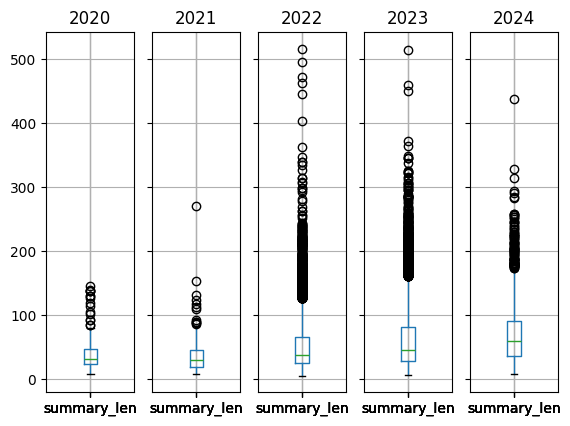

In [39]:
df.groupby("news_date").boxplot(
    column="summary_len", sharex=True, layout=(1, 5), grid=True
);

В 2024 году самый большой размах длин саммари, медиана находится на самом большом уровне количества слов. при этом выбросов не так много, как, например, в 2022 и 2023 году.

Посмотрим длины саммари по количеству продуктов и стран.

In [50]:
data = df.groupby("prod_num").agg({'summary_len':['min', 'mean', 'max', 'count']})
data

summary_len                       
                 min        mean  max count
prod_num                                   
1                  5   51.782971  349  7446
2                  6   55.107296  463  5592
3                  7   56.274414  327  3881
4                  7   56.465630  339  2764
5                  6   61.154968  345  1852
6                  8   62.165899  514  1302
7                  8   62.905447  373   973
8                  9   69.066581  307   781
9                 10   74.127530  345   494
10                 6   74.014286  338   350
11                11   70.132450  239   302
12                13   71.775424  473   236
13                10   82.136842  517   190
14                12   85.251613  438   155
15                12   87.682171  348   129
16                13   83.493976  346    83
17                11   80.361446  451    83
18                14   82.600000  496    50
19                18   77.771429  224    35
20                16   70.965517  257    29
21                11   95.166667  254    36
22                21   89.481481  460    27
23                25   94.761905  247    21
24                14   86.857143  246    14
25                16   98.071429  256    14
26                12   76.583333  240    12
27                11  116.375000  365     8
28                37  118.666667  218     3
29                24   36.000000   42     4
30                11   70.500000  212     8
31                37   86.000000  227     6
32                47  125.750000  216     4
33                26   83.666667  154     6
34                31   81.142857  144     7
35                42   54.000000   66     2
36                72   72.000000   72     1
37                37   67.750000  108     4
38                39   39.000000   39     1
41                22   39.666667   64     3
42               105  105.000000  105     1
44                31   31.000000   31     1
45                38   38.000000   38     1
46                28  103.500000  179     2
52               100  100.000000  100     1
57               127  127.000000  127     1
60                30   30.000000   30     2
66                60   60.000000   60     1
73               446  446.000000  446     1
74                61   61.000000   61     1
100              234  234.000000  234     1

In [52]:
data.sort_values(("summary_len", "mean")).head(10)

summary_len                      
                 min       mean  max count
prod_num                                  
60                30  30.000000   30     2
44                31  31.000000   31     1
29                24  36.000000   42     4
45                38  38.000000   38     1
38                39  39.000000   39     1
41                22  39.666667   64     3
1                  5  51.782971  349  7446
35                42  54.000000   66     2
2                  6  55.107296  463  5592
3                  7  56.274414  327  3881

Новости, в которых до 10 продуктов

array([[<Axes: title={'center': 'summary_len'}>]], dtype=object)

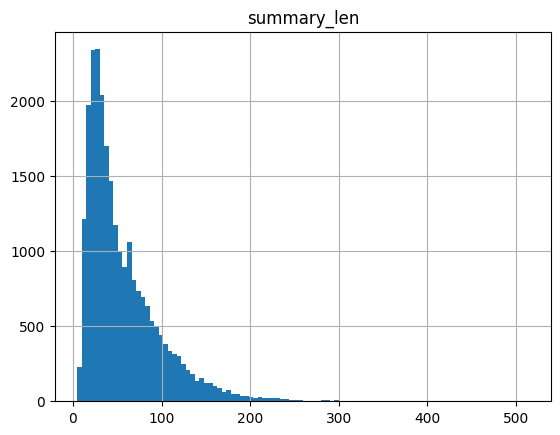

In [41]:
df[df.prod_num < 10].hist(column="summary_len", sharex=True, grid=True, bins=100)

In [42]:
df[(df.prod_num < 10) & ((df.summary_len > 400))]

,text,raw_product,product,raw_locations,locations,news_date,url,summary,lang,text_words,...,country_lemmas,num_summary_sents,text_len,summary_len,text_unique_len,summary_unique_len,prod_num,locs_num,prod_locs_num,raw_locs_num
11992,"РФ с 1 по 30 октября отгрузила на экспорт 5,35...","Ейск, зерно, зерновые культуры, кукуруза, пшен...","зерно, зерновые культуры, кукуруза, пшеница, п...","Алжир, Американская, Ангола, Бангладеш, европе...","Россия, Турция, Египет, Бангладеш, Иран, Алжир...",2023,https://agroobzor.ru/news/rzs-rossiya-s-1-po-3...,В мониторинге Российского зернового союза сооб...,ru,"[рф, с, 1, по, 30, октября, отгрузила, на, экс...",...,"{россия, рф, ангола, египет, мексика, саудовск...",25,977,514,356,209,6,17,23,22
17289,Выручка от бразильского экспорта говядины за п...,"говядина, отгружённый",NaN,"Бразилия, бразильская, бразильский, Египет, Из...","Бразилия, ЕС, Египет, Израиль, Китай, США",2022,https://meatinfo.ru/news/viruchka-ot-eksporta-...,Выручка от бразильского экспорта говядины за п...,ru,"[выручка, от, бразильского, экспорта, говядины...",...,"{египет, соединить штат, китай, израиль, брази...",16,527,463,223,175,2,6,8,7
17444,Куда и сколько? В ФРГ рассказали об импорте и ...,"электротехника, электротехническая и электронн...",NaN,"Австрия, Бельгия, Великобритания, Германия, Ев...","Австрия, Бельгия, Великобритания, Германия, Ис...",2022,https://rossaprimavera.ru/news/41f1d601,Импорт электротехнической и электронной продук...,ru,"[куда, и, сколько, ?, в, фрг, рассказали, об, ...",...,"{россия, великобритания, испания, южный корея,...",16,513,404,198,128,2,14,16,18


Смотрим новости с количеством продуктов больше 40

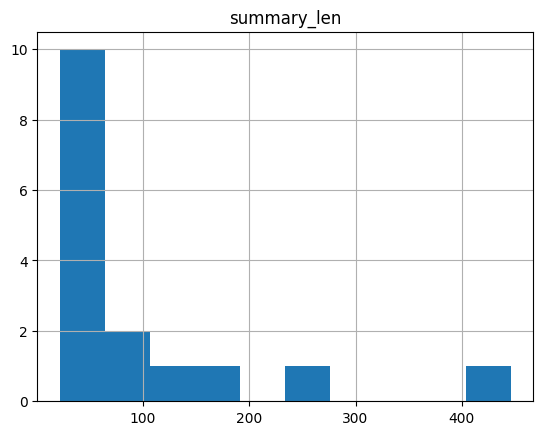

In [43]:
df[df.prod_num > 40].hist(column="summary_len", sharex=True, grid=True);

Посмотрим длину саммари для разного количества стран

In [47]:
data = df.groupby("locs_num").agg({"summary_len": ["min", "mean", "max", "count"]})
data.sort_values(("summary_len", "count"), ascending=False)

summary_len                        
                 min        mean  max  count
locs_num                                    
2                  6   46.843153  460  14020
3                  8   56.040792  496   4241
1                  5   54.971721  373   3324
4                 10   73.577867  298   1753
5                 14   87.396734  285   1041
6                 19  100.966245  463    711
7                 10   98.619256  446    457
8                 13   87.427918  473    437
9                  6   93.025641  363    312
10                14   99.735450  438    189
11                14  116.359375  451    128
12                24  129.247191  301     89
13                15  126.966102  286     59
14                27  143.187500  404     32
15                54  162.517241  517     29
18                55  145.750000  248     16
20                22  133.769231  287     13
17                53  180.166667  514     12
16                69  178.583333  316     12
19                22  146.181818  327     11
22                52  185.200000  322     10
21                17  111.857143  280      7
23               121  174.250000  227      4
24               116  211.666667  290      3
26               110  153.333333  203      3
29                35   54.500000   74      2
25                96   96.000000   96      1
28                49   49.000000   49      1
30               103  103.000000  103      1
32               228  228.000000  228      1
33                97   97.000000   97      1
53                31   31.000000   31      1

Посмотрим на количество продуктов для самых длинных в среднем новостей

In [49]:
data.sort_values(("summary_len", "mean"), ascending=False).head(10)

summary_len                       
                 min        mean  max count
locs_num                                   
32               228  228.000000  228     1
24               116  211.666667  290     3
22                52  185.200000  322    10
17                53  180.166667  514    12
16                69  178.583333  316    12
23               121  174.250000  227     4
15                54  162.517241  517    29
26               110  153.333333  203     3
19                22  146.181818  327    11
18                55  145.750000  248    16

In [53]:
data = df.groupby("prod_locs_num").agg({"summary_len": ["min", "mean", "max", "count"]})
data.sort_values(("summary_len", "count"), ascending=False)

summary_len                       
                      min        mean  max count
prod_locs_num                                   
3                       7   43.733115  221  4886
4                       6   48.151837  335  4518
5                       7   50.006194  306  3713
6                       6   54.813633  345  2978
7                       8   61.497689  251  2164
8                       8   66.368483  463  1688
9                       9   68.753915  304  1341
10                      6   70.768571  349  1050
2                       5   48.811346  203   758
11                      6   74.808108  339   740
12                     10   74.413738  294   626
13                     12   81.332008  322   503
14                     13   85.529563  314   389
15                     10   82.329787  306   282
16                     12   90.203187  404   251
17                     14   91.024752  346   202
18                     12   93.567376  345   141
19                     11   99.620155  316   129
20                     14  112.182796  473    93
21                     18  114.234568  496    81
22                     11  116.893333  327    75
23                     16  105.266667  514    60
24                     13  128.755556  460    45
25                     17   84.000000  248    33
26                     14  112.160000  246    25
27                     16   97.590909  256    22
29                     11  108.722222  348    18
28                     12  154.066667  517    15
30                     24   97.785714  218    14
33                     11  126.636364  254    11
32                     35   89.750000  217     8
31                     41  139.285714  237     7
36                     31   94.428571  290     7
34                     60  145.500000  365     6
35                     26  116.666667  229     6
37                     66  122.600000  216     5
39                     37   77.600000  117     5
38                     79  157.500000  236     2
40                     39   71.000000  103     2
62                     30   30.000000   30     2
42                    117  164.500000  212     2
43                     22   27.500000   33     2
45                     31   47.500000   64     2
46                     38   71.500000  105     2
68                     60   60.000000   60     1
80                    446  446.000000  446     1
76                     61   61.000000   61     1
55                     31   31.000000   31     1
60                    127  127.000000  127     1
44                     42   42.000000   42     1
54                    100  100.000000  100     1
49                    227  227.000000  227     1
48                     28   28.000000   28     1
47                    179  179.000000  179     1
41                    258  258.000000  258     1
102                   234  234.000000  234     1

In [54]:
data.sort_values(("summary_len", "mean"), ascending=False).head(10)

summary_len                       
                      min        mean  max count
prod_locs_num                                   
80                    446  446.000000  446     1
41                    258  258.000000  258     1
102                   234  234.000000  234     1
49                    227  227.000000  227     1
47                    179  179.000000  179     1
42                    117  164.500000  212     2
38                     79  157.500000  236     2
28                     12  154.066667  517    15
34                     60  145.500000  365     6
31                     41  139.285714  237     7

Максимальное количество новостей в диапазоне 2-10 продуктов + локаций.

array([[<Axes: title={'center': 'summary_len'}>]], dtype=object)

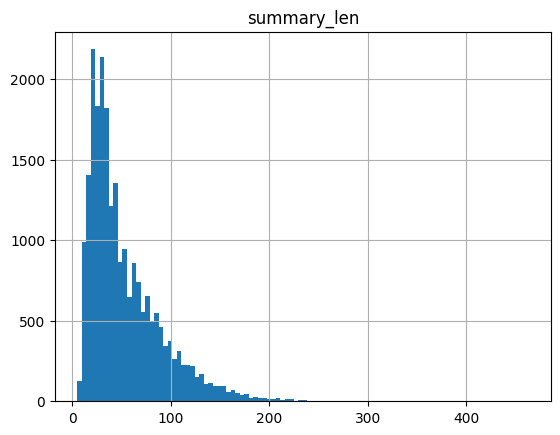

In [55]:
df[df.prod_locs_num <= 10].hist(column="summary_len", sharex=True, grid=True, bins=100)

array([[<Axes: title={'center': "('summary_len', 'max')"}>]], dtype=object)

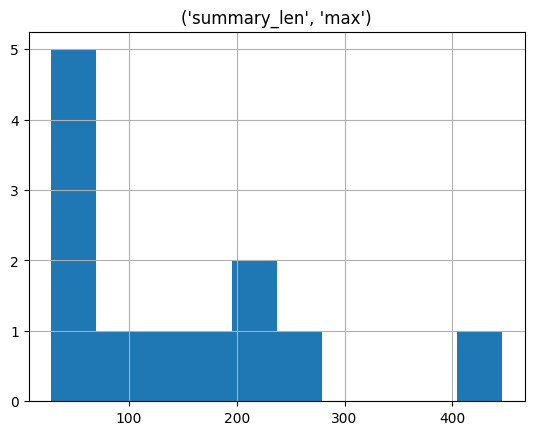

In [56]:
data[data[("summary_len", "count")]==1].hist(column=("summary_len", "max"), sharex=True, grid=True)

Посмотрим, сколько продуктов попадает в саммари

In [57]:
df[df["prod_num"] == 100]["raw_product"].values[0]

'-, 6, 8, A01Z, Bz-углеводороды, C20A, C20B, C20C, C21Z, C26C, C26D, C26E, C26F, C26G, C28A, C29A, C29B, C30A, C30B, C30C, C30E, азотные продукты, аквакультура, Алюминий, бытовая техника, бытовые отходы, Готовая и консервированная рыба, деревянные изделие, Доля, Железные руда, жиры, жмыхи, Зерновые и, изделие, Измерительные, Измерительные средство, Каменный уголь, картон, кожа, косметические препараты, крахмальные продукты, лесная, лесное хозяйство, магнитные и оптические носители, макарон. изделие, Машина, Медицинское диагностическое оборудование, Металлургическая, металлургические и металлические изделие, Молочная продукция, мясная продукция, Мясо, неорганические химические вещество, оборудование общее назначение, обувь, овощи, одежда, Основные химические вещество, отходы, парфюмерия, Парфюмерная продившийся, первичные стальные изделие, пищевые продукты, пластмасса, пластмассовые, природные углеводороды, продукты нефтепереработка, Продукты растениеводство и животноводство, Продукция 

In [58]:
i = 0
for prod in set(df[df["prod_num"] == 100]["raw_product"].values[0].split(", ")):
    if prod in df[df["prod_num"] == 100]["summary"].values[0]:
        i += 1

i

3

Чтобы точно посчитать матчинг продуктов и локаций с саммари, будем смотреть на совпадение лемматизированных продуктов/саммари с лемматизированным саммари.

In [60]:
def get_match(df, feature, col):
    df[col] = 0
    for i, row in df.iterrows():
        match = 0
        for prod in row[feature]:
            if prod in " ".join(row["summary_lemmas"]):
                match += 1
        df.at[i, col] = match
    return df

In [61]:
df = get_match(df, "product_lemmas", "prod_match")
df = get_match(df, "country_lemmas", "locs_match")

<Axes: ylabel='prod_match'>

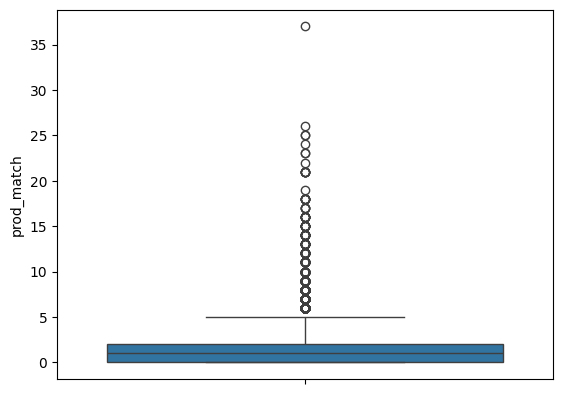

In [62]:
sns.boxplot(df["prod_match"])

<Axes: ylabel='locs_match'>

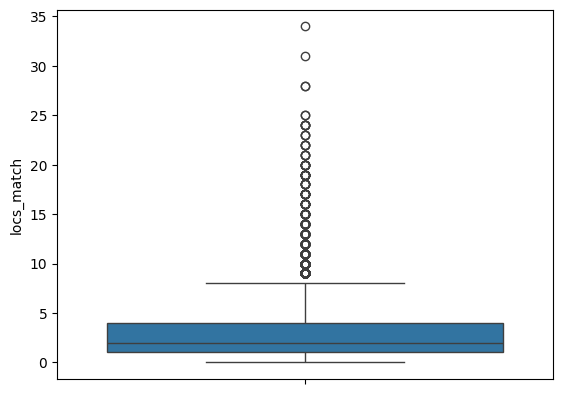

In [63]:
sns.boxplot(df["locs_match"])

<Axes: >

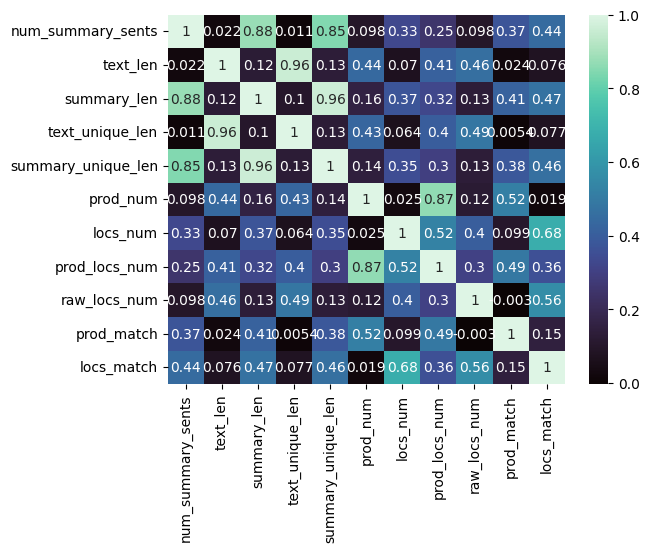

In [64]:
plt.figsize = (10, 8)
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="mako")

Посмотрим совпадения в продуктах

In [66]:
df[(df["prod_match"] - df["prod_num"]) == 0].shape

(8066, 26)

In [67]:
df[df["prod_match"] - df["prod_num"] == 0]["lang"].value_counts()

lang
ru    7100
en     966
Name: count, dtype: int64

Доля предложений для языков

Русский

In [69]:
df[df["prod_match"] - df["prod_num"] == 0]["lang"].value_counts().values[0] / df[
    "lang"
].value_counts().values[0] * 100

36.33014378549864

Английский

In [70]:
df[df["prod_match"] - df["prod_num"] == 0]["lang"].value_counts().values[1] / df[
    "lang"
].value_counts().values[1] * 100

13.092979127134724

У 8066 записей все продукты упомянуты в саммари. 
Для русских саммари доля таких текстов 36%,  английских - 13%



Смотрим тексты, в которых не совпал ни один продукт

In [71]:
df[df["prod_match"] == 0].shape

(6840, 26)

Таких текстов 6840. Это 25,4% текстов.

In [72]:
df[df["prod_match"] == 0]["lang"].value_counts()

lang
ru    4664
en    2176
Name: count, dtype: int64

In [73]:
df[df["prod_match"] == 0]["lang"].value_counts().values[0] / df[
    "lang"
].value_counts().values[0] * 100

23.86532262191066

In [74]:
df[df["prod_match"] == 0]["lang"].value_counts().values[1] / df[
    "lang"
].value_counts().values[1] * 100

29.493087557603687

Это 23,8% русских текстов и 29,4% англиских

В английских статьях товар может относиться к коду 93. Не всегда понятно, что это за товар - надо дать в саммари контекст для читателей. Или описать, какой это товар, т.к. российский читатель может быть не знаком с ним.


Часто длина новости увеличивается из-за того, что приходится дать какой-то контекст (например, в статье про снятие санкций, надо напомнить, что санкции были введены - какие и когда). Эта информация есть в статье, но не всегда очевидно, что этот контекст надо взять.

Посмотрим на количество продуктов при матче = 0

In [76]:
df[df["prod_match"] == 0]["prod_num"].value_counts()

prod_num
1     2723
2     1524
3      882
4      608
5      330
6      239
7      159
8      121
9       53
10      34
11      33
12      26
13      20
15      19
14      17
17      11
18       6
16       5
19       5
22       5
20       5
21       4
23       3
24       2
34       1
27       1
30       1
44       1
38       1
60       1
Name: count, dtype: int64

Посмотрим на новости с большим количеством продуктов, которые не попали в саммари

In [77]:
data = df[(df["prod_match"] == 0) & (df["prod_num"] > 25)]
data.shape

(6, 26)

In [78]:
for i in range(data.shape[0]):
    print(data.iloc[i]["prod_num"])
    print(data.iloc[i]["summary"])
    print(data.iloc[i]["raw_product"])
    print('*'*50)

27
Россия больше не раскрывает данные по внешней торговле, но информации торговых партнеров хватает, чтобы сделать выводы о трансформации в этой сфере. Партнером номер один для России стал Китай, а Турция — главным транзитным хабом.
Brent, ESPO, G7, Urals, газа, двигатели внутреннее сгорание, Компьютерные, компьютерные части, компьютеры, котлы, металлорежущие станки, механические устройство, микропроцессоры, нагревательное оборудование, нефтепродукты, нефть, нефтяники, оборудование, подъёмники, потребительская электроника, сальдо, сельхозтовары, сервера, удобрения, цветные металлы, электронные компонента, энергоносители
**************************************************
34
Российских бизнесменов интересует как экспорт, так и импорт из Армении. Есть потенциал для развития сотрудничества в области туризма и индустрии, но важно внедрение инновационных решений и идей.
бытовая химия, драгоценные камни, жемчуг, запасные часть, комплектующие, консервация, косметика, машина, металлы, напитки, 

Есть большая статья. В 1-2 параграфе есть важная, новая информация. Эта часть статьи важна. Вторая часть статьи - контекст, много товаров, историческая справка и это уже не нужно. Такие статьи начинаются со слов "Напомним что".

Нет окончательного понимания, как влияют продукты на длину саммари и количество предложений.

Часто бывает, что при большом количестве одинаковых продуктов, они сгруппировываются в одно слово или одну категорию. В таком случае матчинг посмотреть не получается.

Посмотрим на совпадение локаций

In [79]:
df[(df["locs_match"] - df["locs_num"]) == 0].shape

(10411, 26)

In [83]:
df[df["locs_match"] - df["locs_num"] == 0]["lang"].value_counts()

lang
ru    8237
en    2174
Name: count, dtype: int64

Доля предложений для языков

Русский

In [81]:
df[df["locs_match"] - df["locs_num"] == 0]["lang"].value_counts().values[0] / df[
    "lang"
].value_counts().values[0] * 100

42.14808371283836

Английский

In [82]:
df[df["locs_match"] - df["locs_num"] == 0]["lang"].value_counts().values[1] / df[
    "lang"
].value_counts().values[1] * 100

29.46597994036324

У 10411 записей все продукты упомянуты в саммари. 
Для русских саммари доля таких текстов 42%,  английских - 30%

Эти показатели гораздо выше, чем совпадения по продукту. Локации имеют большее влияние (по ТЗ мы больше внимания должны уделить всем странам) В свою очередь продукты могут сгруппироваться в один код.

Смотрим тексты, в которых не совпала ни одна локация

In [84]:
df[df["locs_match"] == 0].shape

(1141, 26)

In [85]:
df[df["locs_match"] == 0]["lang"].value_counts()

lang
en    623
ru    518
Name: count, dtype: int64

In [86]:
df[df["locs_match"] == 0]["lang"].value_counts().values[0] / df[
    "lang"
].value_counts().values[0] * 100

3.1878421941360076

In [88]:
df[df["locs_match"] == 0]["lang"].value_counts().values[1] / df[
    "lang"
].value_counts().values[1] * 100

7.020872865275142

В 1141 текстах не совпал ни одна локация. Это 4% текстов.
3% русских текстов и 7% англиских

In [89]:
df[(df["locs_match"] == 0) & (df["prod_match"] == 0)].shape

(360, 26)

В 360 текстах нет вообще совпадений продукта и локации

In [91]:
no_match = df[(df["locs_match"] == 0) & (df["prod_match"] == 0)]

In [92]:
no_match.to_excel('./data/no_match.xlsx', index=False)

/home/dasha/.pyenv/versions/3.11.2/lib/python3.11/site-packages/xlsxwriter/worksheet.py:1252: UserWarning: Ignoring URL 'https://ria.ru/20230424/egipet-1867393544.html%20Рейсов%20в%20Египет%20из%20России%20станет%20больше%20Рейсов%20в%20Египет%20из%20России%20станет%20больше%20-%20РИА%20Новости,%2024.04.2023%20Рейсов%20в%20Египет%20из%20России%20станет%20больше%20С%20середины%20мая%20еще%20один%20перевозчик%20–%20AZUR%20air%20–%20будет%20летать%20из%20Москвы%20в%20Хургаду%20и%20Шарм-эш-Шейх,%20сообщает%20TourDom.ru.%20РИА%20Новости,%2024.04.2023%202023-04-24T17:15%202023-04-24T17:15%202023-04-24T17:15%20туризм%20новости%20-%20туризм%20туризм%20туристы%20хургада%20египет%20шереметьево%20(аэропорт)%20coral%20travel%20/html/head/meta%5b@name='og:title'%5d/@content%20/html/head/meta%5b@name='og:description'%5d/@content%20https://cdnn21.img.ria.ru/images/151372/85/1513728538_0:3:1036:586_1920x0_80_0_0_cce67126fc980d064292144bc35ce797.jpg%20МОСКВА,%2024%20апр%20—%20РИА%20Новости.%20С%20серед

После визуального анализа этих новостей видно, что такое отсутствие совпадений связано с такими случами:
- "панама" - в локациях а в саммари - "Панамский канал", 'japanese', 'japan' -> 'Asian'
- страны группируются в союзы - ЕАС, БРИКС и т.п.
- ошибки NER - например, для новости про автомобили выделен продукт только продукт "бензиновый", который не попадает в саммари
- буква "ё" стоит в продукте, отстутвует в саммари